# Trabalho Computacional 3. Rede Convolucional e Transfer Learning

> **Nome**: *Gabriel Martins Silveira de Oliveira*.  
> **Matrícula**: 190042656.


# Google colab & imports

In [3]:
import sys
import subprocess

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    try:
        subprocess.run(
            ["pip", "install", "pytorch-lightning", "torchmetrics"], check=True
        )
        print("Successfully installed packages.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing packages: {e}")
else:
    print("Not running in Google Colab")

Not running in Google Colab


In [24]:
# PyTorch
import torch
import torch.nn as nn
from torch import optim, Generator
from torch.utils.data import random_split, Subset, DataLoader

# TorchVision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import (
    vgg16, 
    VGG16_Weights, 
    inception_v3, 
    Inception_V3_Weights,
)

# TorchMetrics
from torchmetrics.functional import accuracy

# TorchLightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# Numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Utils
from pathlib import Path
from argparse import Namespace
from typing import List, Tuple, cast

## Base de Dados

### A base de dados é a [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).  

Ela contém 60000 imagens 32x32 coloridas (3 canais) das seguintes categorias de objetos: 

In [5]:
class CIFAR10DataSet():   
    train: Subset[datasets.CIFAR10]
    val: Subset[datasets.CIFAR10]
    test: datasets.CIFAR10
    classes: List[str]
    resize: Tuple[int, int]
    
    def __init__(
        self, 
        root: Path, 
        resize: Tuple[int, int]=(224, 224),
    ):  
        trans = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.5, 0.5, 0.5), 
                (0.5, 0.5, 0.5),
            )
        ])
        
        self.full_train = datasets.CIFAR10(root=root, train=True, transform=trans, download=True)
        
        self.classes = self.full_train.classes
        
        train_set_size = int(len(self.full_train) * 0.8)
        valid_set_size = len(self.full_train) - train_set_size
        
        seed = Generator().manual_seed(42)
        self.train, \
        self.val = random_split(
            self.full_train, 
            [train_set_size, valid_set_size], 
            generator=seed
        )
        
        self.test = datasets.CIFAR10(root=root, train=False, transform=trans, download=True)

In [ ]:
num_workers = 4
root = Path("./.data/")
root.mkdir(parents=True, exist_ok=True)

In [ ]:
dataset = CIFAR10DataSet(root=root)

train_dataloader = DataLoader(
    dataset.train,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)
val_dataloader = DataLoader(
    dataset.val,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)
test_dataloader = DataLoader(
    dataset.test,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
    pin_memory=True,
)

print(
    f"Number of training examples: {len(dataset.train)}\n"
    f"Number of validation examples: {len(dataset.val)}\n"
    f"Number of test examples: {len(dataset.test)}\n\n"
    f"Number of Classes: {len(dataset.classes)}\n"
    "Classes:",
    *dataset.classes,
    sep="\n  ",
)

Number of training examples: 40000
Number of validation examples: 10000
Number of test examples: 10000

Number of Classes: 10
Classes:
  airplane
  automobile
  bird
  cat
  deer
  dog
  frog
  horse
  ship
  truck


In [8]:
def imshow_batch(
    images_batch: torch.Tensor,
    labels_batch: torch.Tensor,
    class_names: List[str],
    mean: float = 0.5,
    std: float = 0.5,
    num_images_to_show: int = 9,
):
    images_batch = images_batch.cpu()

    axes_grid_array: np.ndarray

    _, axes_grid_array = plt.subplots(
        3, 3, figsize=(10, 10)
    )

    axes_flat_array = axes_grid_array.flatten()

    for i in range(min(num_images_to_show, len(images_batch))):
        ax = axes_flat_array[i]
        assert isinstance(ax, Axes), "Each element should be an Axes object" # Pylance...

        # We need to unnormalize the image ):
        img = images_batch[i]
        img = img * std + mean
        img = img.permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)
        
        ax.imshow(img.numpy())
        label_index: int = int(labels_batch[i].item())
        ax.set_title(f"Label: {class_names[label_index]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Displaying a batch of training images after transforms:


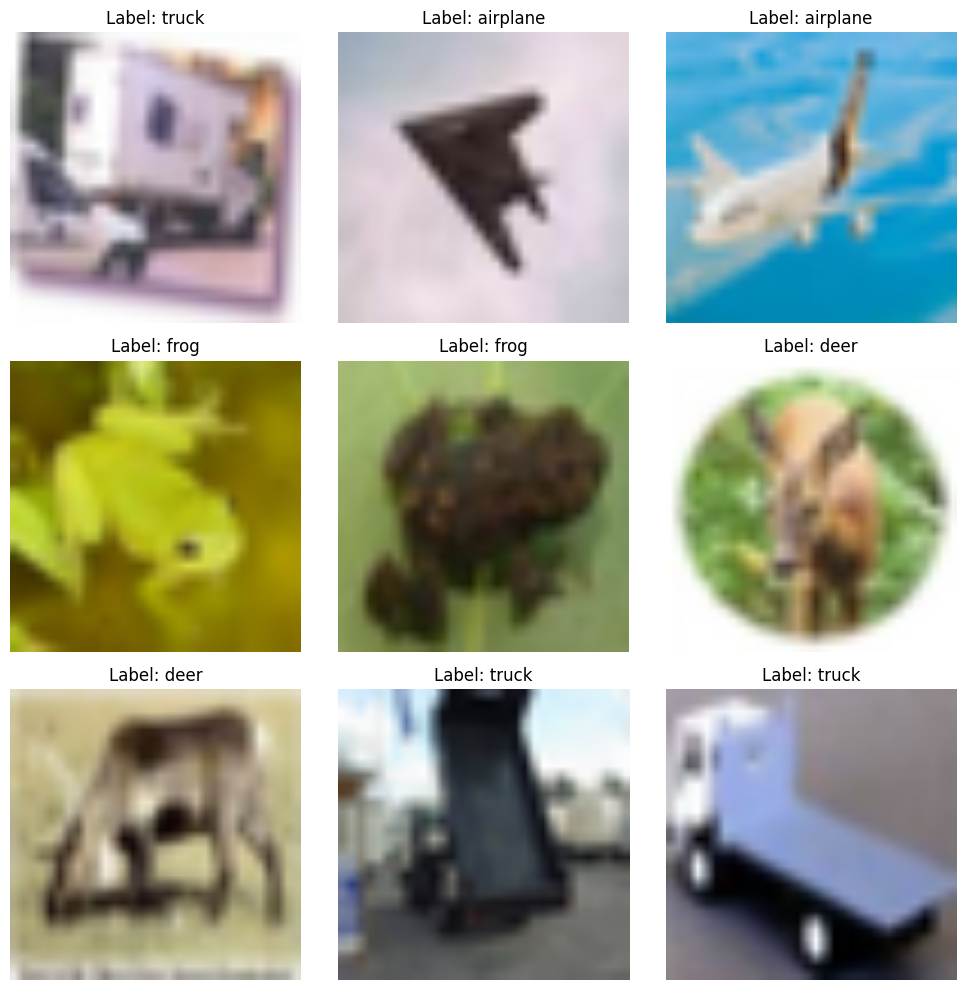

In [9]:
data_iter = iter(train_dataloader)
try:
    images, labels = next(data_iter)
    
    print("Displaying a batch of training images after transforms:")
    imshow_batch(images, labels, dataset.classes, num_images_to_show=9)

except StopIteration:
    print("DataLoader is empty or could not fetch a batch.")

# Treinando um MLP

Use esta base de dados para treinar um Perceptron Multicamadas, como feito no trabalho anterior com a base MNIST. Escolha um MLP com 2 camadas escondidas. Não perca muito tempo variando a arquitetura porque este problema é difícil sem o uso de convoluções e o resultado não será totalmente satisfatório.

Você pode usar este código, baseado na biblioteca [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) como base para definição da rede:

In [10]:
class ModelHParams(Namespace):
    lr: float
    num_classes: int
    weight_decay: float  # L2 Regularization
    l1_strength: float  # L1 Regularization


class LightModel(pl.LightningModule):
    model: nn.Module
    hparams: ModelHParams

    def __init__(
        self,
        model: nn.Module,
        lr: float = 1e-3,
        num_classes: int = 10,
        weight_decay: float = 0.0,  # No L2 regularization
        l1_strength: float = 0.0,  # No L1 regularization
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        X, y = batch
        y_hat: torch.Tensor = self(X)
        cross_entropy_loss = nn.functional.cross_entropy(y_hat, y)
        total_loss = cross_entropy_loss

        if self.hparams.l1_strength > 0:
            total_loss = self._deal_with_l1(total_loss)
            self.log(
                "train_cross_entropy_loss",
                cross_entropy_loss,
                on_step=True,
                on_epoch=True,
                prog_bar=False,
            )

        self.log(
            "train_loss",
            total_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            sync_dist=True,
        )
        return total_loss

    def _deal_with_l1(self, total_loss: torch.Tensor) -> torch.Tensor:
        l1_penalty = 0.0
        for param in self.model.parameters():
            if param.requires_grad:
                l1_penalty += torch.norm(param, 1)  # L1 norm
        total_loss += self.hparams.l1_strength * l1_penalty
        return total_loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        X, y = batch
        y_hat: torch.Tensor = self(X)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log(
            "val_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor]):
        X, y = batch
        y_hat: torch.Tensor = self(X)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(
            preds,
            y,
            task="multiclass",
            num_classes=self.hparams.get("num_classes", 10),
        )
        self.log("test_acc", acc, on_epoch=True)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log("test_loss", loss, on_epoch=True)

    def configure_optimizers(self) -> optim.Optimizer:
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        return optimizer

## Sem L1 e L2 ou droput Basico

In [11]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 224 * 224, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)

mlp = LightModel(arch)

In [12]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)

trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)
print("\n--- Training MLP classifier ---")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Dev\Coding\personal\Curso\ML\ENE0082\Trabalhos\Trabaho 3\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.6 


--- Training MLP classifier ---
Epoch 15: 100%|██████████| 625/625 [00:49<00:00, 12.70it/s, v_num=3, train_loss_step=1.360, val_loss=1.600, train_loss_epoch=1.370]


In [13]:
print("\n--- Testing MPL classifier ---")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier ---
Testing DataLoader 0: 100%|██████████| 157/157 [00:06<00:00, 22.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4438000023365021
        test_loss           1.5723711252212524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4438000023365021, 'test_loss': 1.5723711252212524}]

## Apenas L1

In [14]:
mlp = LightModel(arch, l1_strength=1e-5)

In [15]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)

trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)
print("\n--- Training MLP classifier ---")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.6 M  | train
---------------------------------------------
9.6 M     Trainable params
0         Non-trainable params
9.6 M     Total params
38.540    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier ---
Epoch 11: 100%|██████████| 625/625 [00:43<00:00, 14.33it/s, v_num=4, train_loss_step=1.770, val_loss=1.610, train_loss_epoch=1.900]


In [16]:
print("\n--- Testing MPL classifier ---")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier ---
Testing DataLoader 0: 100%|██████████| 157/157 [00:08<00:00, 17.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.42899999022483826
        test_loss           1.5989538431167603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.42899999022483826, 'test_loss': 1.5989538431167603}]

## Apenas L2

In [ ]:
mlp = LightModel(arch, weight_decay=1e-5)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)

trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)
print("\n--- Training MLP classifier ---")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

In [ ]:
print("\n--- Testing MPL classifier ---")
trainer.test(model=mlp, dataloaders=test_dataloader)

## L1 e L2

In [ ]:
mlp = LightModel(arch, weight_decay=1e-5)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)

trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)
print("\n--- Training MLP classifier ---")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

In [ ]:
print("\n--- Testing MPL classifier ---")
trainer.test(model=mlp, dataloaders=test_dataloader)

## Dropout

In [ ]:
dropout_p = 0.3
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 224 * 224, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(16, 10),
)

mlp = LightModel(arch, weight_decay=1e-5)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    mode="min",
    min_delta=0.001,
)

trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)
print("\n--- Training MLP classifier ---")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

In [ ]:
print("\n--- Testing MPL classifier ---")
trainer.test(model=mlp, dataloaders=test_dataloader)

## Uso da rede VGG16 pré-treinada

Lembre-se que a rede VGG usa como bloco básico cascata de convoluções com filtros 3x3, com "padding" para que a imagem não seja
diminuída, seguida de um "max pooling" reduzindo imagens pela metade. O número de mapas vai aumentando e seu tamanho vai diminuindo
ao longo de suas 16 camadas. Este é um modelo gigantesco e o treinamento com recursos computacionais modestos levaria dias ou
semanas, se é que fosse possível.

No entanto, vamos aproveitar uma característica central das grandes redes convolucionais. Elas podem ser usadas como pré-processamento
fixo das imagens, mesmo em um novo problema (lembre-se, a rede VGG original foi treinada na base ImageNet, que tem muitas categorias de
imagens).

O código abaixo realiza o download do modelo treinado e configura os seus parâmetros como não ajustáveis.

In [17]:
model_vgg = vgg16(weights=VGG16_Weights.DEFAULT, progress=True)

for param in model_vgg.parameters():
    param.requires_grad = False

In [18]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
num_vgg_output_features = cast(int, model_vgg.classifier[0].in_features)  # Pylance...

## Basico sem L1 e L2 ou droupout

In [26]:
new_custom_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_vgg_output_features, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)
model_vgg.classifier = new_custom_classifier

light_vgg_model = LightModel(model=model_vgg)

In [27]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)


trainer_for_vgg = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)


print("\n--- Training VGG16 with custom classifier ---")
trainer_for_vgg.fit(
    model=light_vgg_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VGG  | 16.3 M | train
---------------------------------------
1.6 M     Trainable params
14.7 M    Non-trainable params
16.3 M    Total params
65.286    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode



--- Training VGG16 with custom classifier ---
Epoch 0:   2%|▏         | 10/625 [02:52<2:56:54,  0.06it/s, v_num=5, train_loss_step=1.820]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
print("\n--- Testing VGG16 with custom classifier ---")
trainer_for_vgg.test(model=light_vgg_model, dataloaders=test_dataloader)

## L1

In [ ]:
light_vgg_model = LightModel(model=model_vgg, l1_strength=1e-4)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)


trainer_for_vgg = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)


print("\n--- Training VGG16 with custom classifier ---")
trainer_for_vgg.fit(
    model=light_vgg_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
print("\n--- Testing VGG16 with custom classifier ---")
trainer_for_vgg.test(model=light_vgg_model, dataloaders=test_dataloader)

## L2

In [ ]:
light_vgg_model = LightModel(model=model_vgg, weight_decay=1e-5)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)


trainer_for_vgg = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)


print("\n--- Training VGG16 with custom classifier ---")
trainer_for_vgg.fit(
    model=light_vgg_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
print("\n--- Testing VGG16 with custom classifier ---")
trainer_for_vgg.test(model=light_vgg_model, dataloaders=test_dataloader)

## Dropout

In [ ]:
dropout_p = 0.3
new_custom_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_vgg_output_features, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(16, 10)
)
model_vgg.classifier = new_custom_classifier

light_vgg_model = LightModel(model=model_vgg)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)


trainer_for_vgg = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator="gpu", devices=1
)


print("\n--- Training VGG16 with custom classifier ---")
trainer_for_vgg.fit(
    model=light_vgg_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
print("\n--- Testing VGG16 with custom classifier ---")
trainer_for_vgg.test(model=light_vgg_model, dataloaders=test_dataloader)